Import libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Load a template and query image

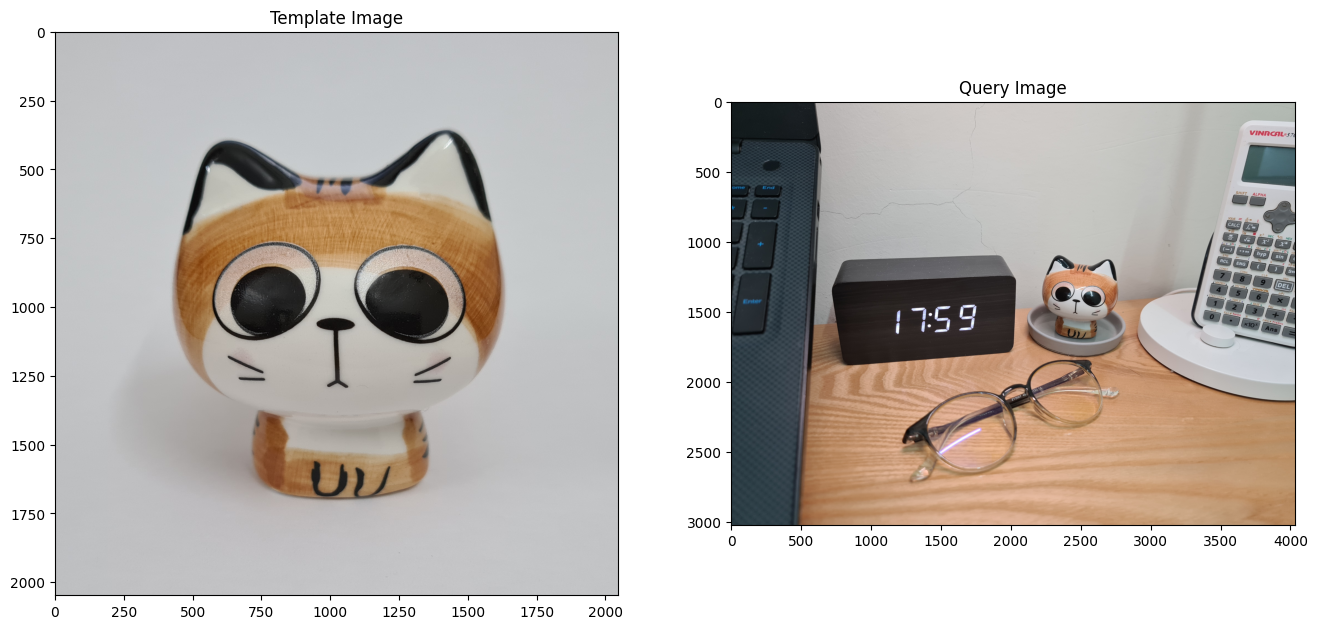

In [2]:
template_img_file = './image/template/cat/brown_cat1.png'
query_img_file = './image/query/scene4.jpg'

# Load the image
template_img = cv2.imread(template_img_file)
query_img = cv2.imread(query_img_file)

template_img = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)

template_gray_img = cv2.imread(template_img_file, cv2.IMREAD_GRAYSCALE)
query_gray_img = cv2.imread(query_img_file, cv2.IMREAD_GRAYSCALE)

# Display the image
fx, plots = plt.subplots(1, 2, figsize=(16, 8))

plots[0].set_title("Template Image")
plots[0].imshow(template_img)

plots[1].set_title("Query Image")
plots[1].imshow(query_img)

plt.show()


Calculate the keypoints and descriptors of template and query image using SIFT

Template image: 2142 keypoints
Query image: 12866 keypoints


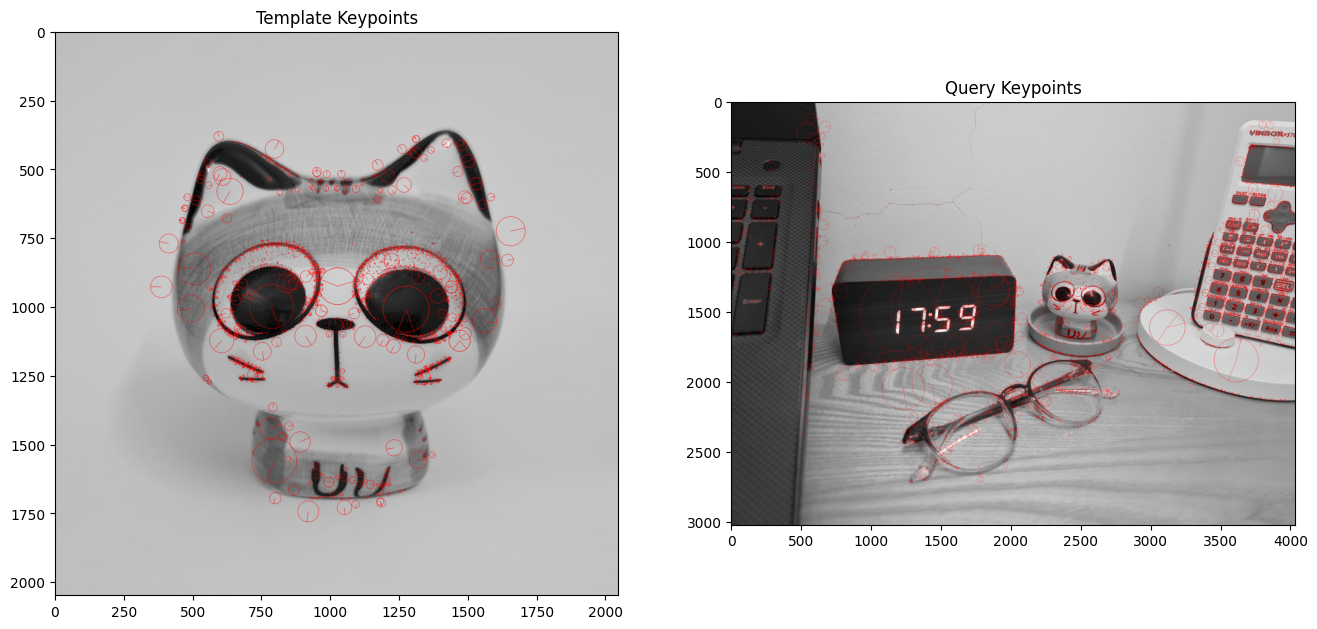

In [3]:
sift = cv2.SIFT_create(contrastThreshold=0.05, edgeThreshold=80)

template_kp, template_des = sift.detectAndCompute(template_img, None)
query_kp, query_des = sift.detectAndCompute(query_img, None)

print('Template image: %s keypoints' % len(template_kp))
print('Query image: %s keypoints' % len(query_kp))

template_kp_img = cv2.drawKeypoints(template_gray_img, template_kp, 0, (255, 0, 0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
query_kp_img = cv2.drawKeypoints(query_gray_img, query_kp, 0, (255, 0, 0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(16, 8))

plots[0].set_title("Template Keypoints")
plots[0].imshow(template_kp_img)

plots[1].set_title("Query Keypoints")
plots[1].imshow(query_kp_img)

plt.show()

Matching descriptors using Brute Force Matcher and Ratio Test

Number of matches: 65


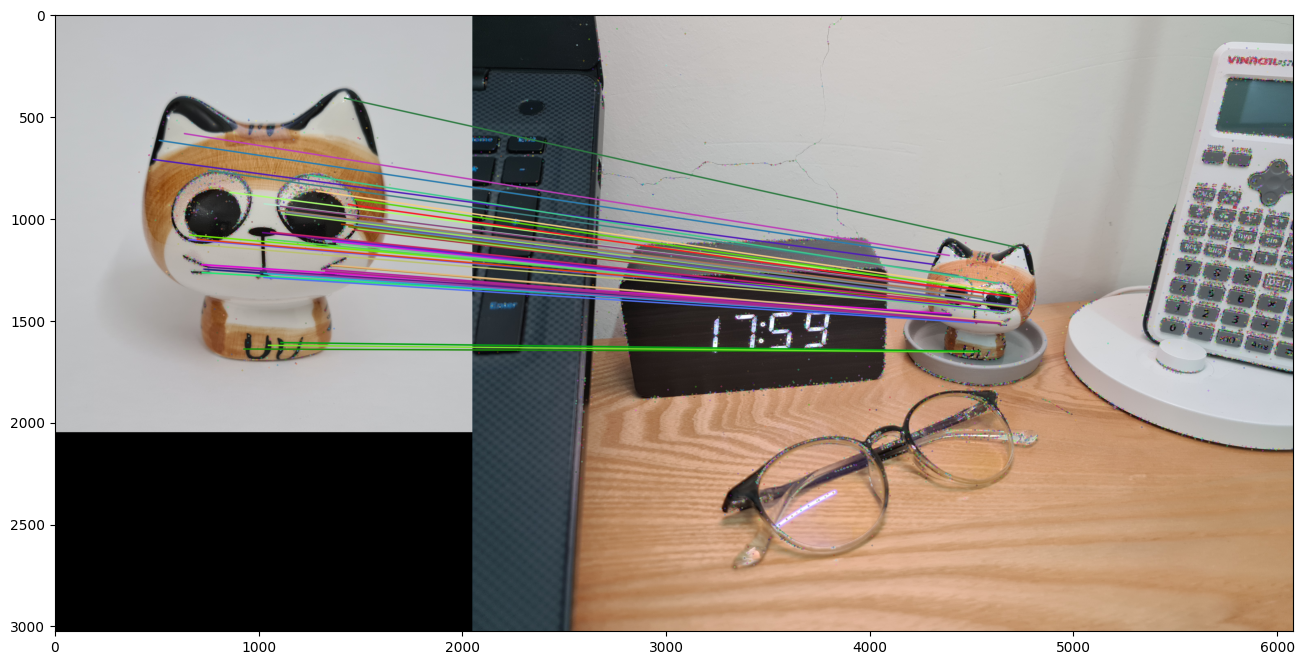

In [4]:
# Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)
matches = bf.knnMatch(template_des, query_des, k=2)

# Ratio Test
good_matches = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good_matches.append(m)

print('Number of matches:', len(good_matches))

match_img = cv2.drawMatches(template_img, template_kp, query_img, query_kp, good_matches, 0, matchesThickness=6)

plt.figure(figsize=(16, 8))
plt.imshow(match_img)
plt.show()

Get the bounding box of matches in query image 

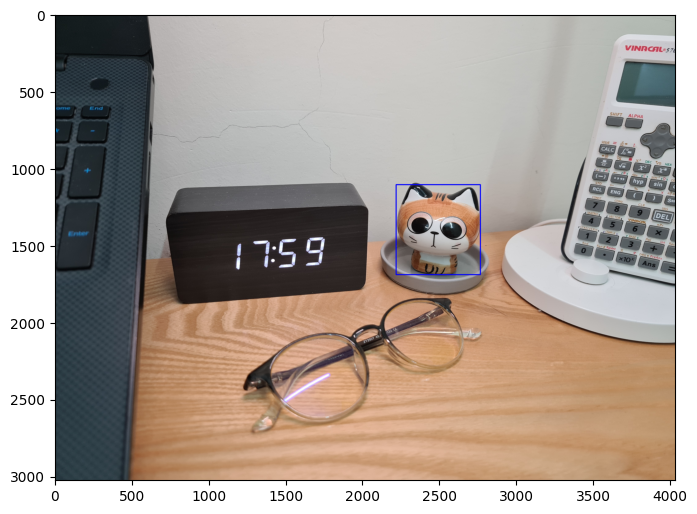

In [5]:
# Find the transformation matrix
template_pts = np.float32([template_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
query_pts = np.float32([query_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(template_pts, query_pts, cv2.RANSAC, 5.0)

if M is None:
    print('%-16s Not enought inliers to calculate homography matrix' % '')
    exit()

# Transform template keypoints to query coordinates
template_pts = np.float32([kp.pt for kp in template_kp]).reshape(-1, 1, 2)
query_pts = cv2.perspectiveTransform(template_pts, M)

# Find the bounding box coordinates
x, y, w, h = cv2.boundingRect(query_pts)

# Draw the bounding box on the scene image
bounding_box_img = np.copy(query_img)
cv2.rectangle(bounding_box_img, (x, y), (x+w, y+h), (0, 0, 255), 6)

plt.figure(figsize=(8, 8))
plt.imshow(bounding_box_img)
plt.show()